In [1]:
from data_loader import DataLoader, EELSLazyLoader
from filters import *
import matplotlib.pyplot as plt
import cv2
fp = '/home/somar/Desktop/own_stuff/cleaning script/example data files/SuperScan-MAADF_2025-02-26T153932.717062_2048x2048_0.ndata1'

ds = DataLoader(fp)

data = ds.raw_data
metadata = ds.raw_metadata

len(data), len(metadata)
img = data[0]
print(img.shape)
print("Size of the image:", img.size, img.size/2048)

# normalize to 0, 255
img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
print(img.min(), img.max())


(2048, 2048)
Size of the image: 4194304 2048.0
2.1889175e-09 255.0


K-means centers: 6.68, 29.92
Midpoint threshold: 18.30 -> Misclassification: 0.00%
Otsu threshold: 17.43 -> Misclassification: 1.57%
Histogram-minimum threshold: 29.88 -> Misclassification: 13.64%


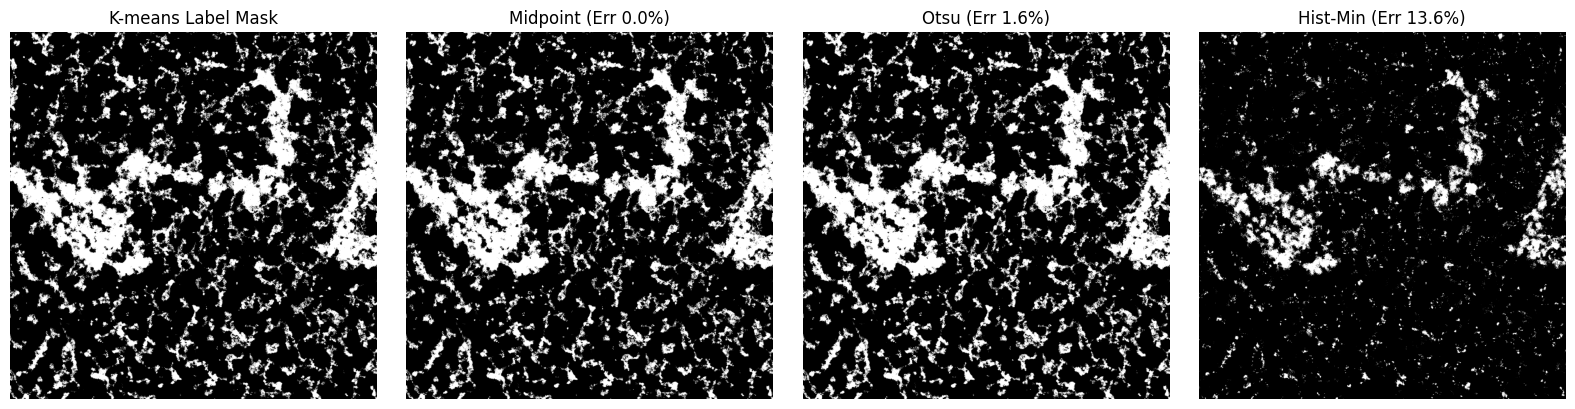

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.filters import threshold_otsu



# Flatten intensities for K-means
pixels = img.reshape(-1, 1)

# ----------- Step 2: Run K-means -----------
kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)
labels = kmeans.fit_predict(pixels)
centers = kmeans.cluster_centers_.flatten()

# Sort centers so c_low < c_high
c_low, c_high = np.sort(centers)

# ----------- Step 3: Midpoint threshold -----------
T_kmeans_mid = (c_low + c_high) / 2

# ----------- Step 4: Otsu threshold -----------
T_otsu = threshold_otsu(img)

# ----------- Step 5: Histogram-minimum threshold -----------
hist, bin_edges = np.histogram(img, bins=256)
min_idx = np.argmin(hist[np.searchsorted(bin_edges, c_low):np.searchsorted(bin_edges, c_high)])
T_hist_min = bin_edges[np.searchsorted(bin_edges, c_low) + min_idx]

# ----------- Step 6: Create masks -----------
mask_kmeans = labels.reshape(img.shape)
mask_midpoint = (img >= T_kmeans_mid).astype(np.uint8)
mask_otsu = (img >= T_otsu).astype(np.uint8)
mask_hist_min = (img >= T_hist_min).astype(np.uint8)

# ----------- Step 7: Misclassification % -----------
def misclass_rate(mask, ref):
    return 100 * np.sum(mask != ref) / mask.size

mis_mid = misclass_rate(mask_midpoint, mask_kmeans)
mis_otsu = misclass_rate(mask_otsu, mask_kmeans)
mis_hist = misclass_rate(mask_hist_min, mask_kmeans)

print(f"K-means centers: {c_low:.2f}, {c_high:.2f}")
print(f"Midpoint threshold: {T_kmeans_mid:.2f} -> Misclassification: {mis_mid:.2f}%")
print(f"Otsu threshold: {T_otsu:.2f} -> Misclassification: {mis_otsu:.2f}%")
print(f"Histogram-minimum threshold: {T_hist_min:.2f} -> Misclassification: {mis_hist:.2f}%")

# ----------- Step 8: Visual comparison -----------
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].imshow(mask_kmeans, cmap='gray'); axs[0].set_title("K-means Label Mask")
axs[1].imshow(mask_midpoint, cmap='gray'); axs[1].set_title(f"Midpoint (Err {mis_mid:.1f}%)")
axs[2].imshow(mask_otsu, cmap='gray'); axs[2].set_title(f"Otsu (Err {mis_otsu:.1f}%)")
axs[3].imshow(mask_hist_min, cmap='gray'); axs[3].set_title(f"Hist-Min (Err {mis_hist:.1f}%)")

for ax in axs: ax.axis('off')
plt.tight_layout()
plt.show()


[<Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>]

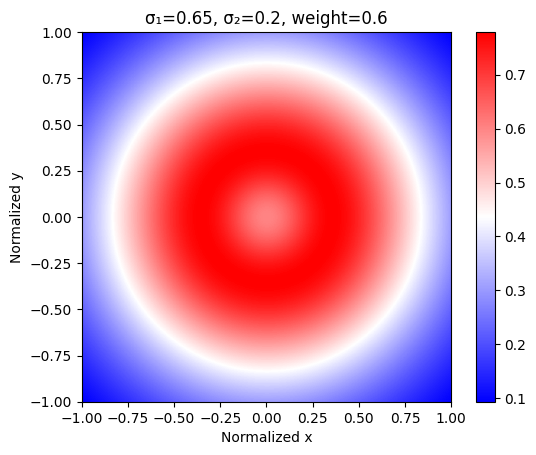

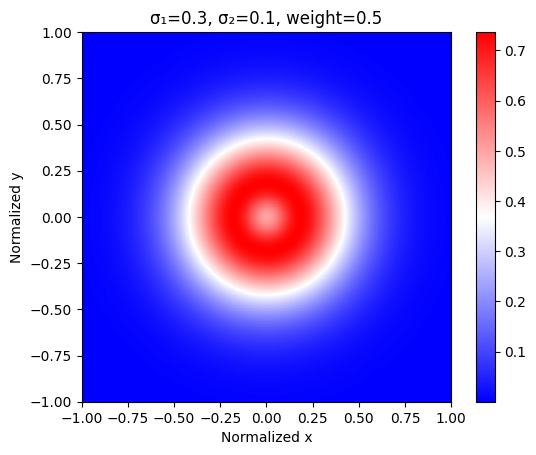

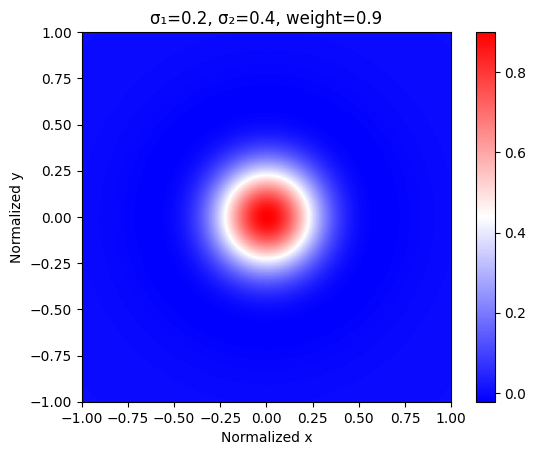

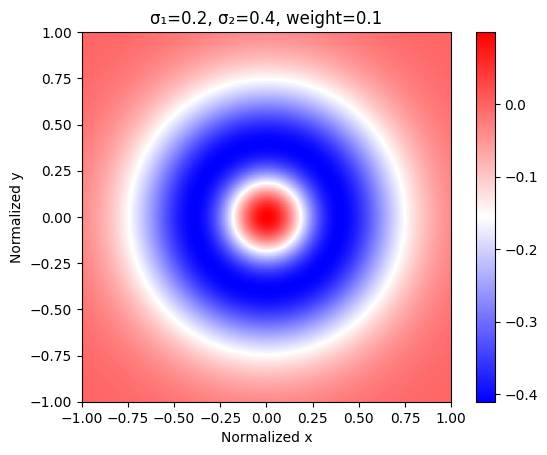

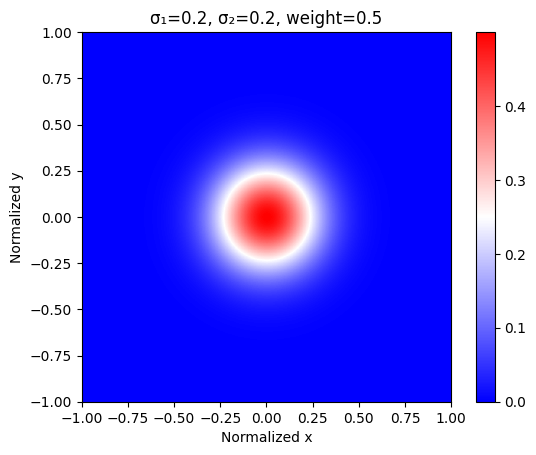

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def dgfilter(shape, params):
    sigma1, sigma2, weight = params
    s1 = sigma1 * sigma1
    s2 = sigma2 * sigma2

    yy_min = -shape[0] // 2
    yy_max = shape[0] // 2
    xx_min = -shape[1] // 2
    xx_max = shape[1] // 2
    yy, xx = np.meshgrid(np.linspace(yy_min, yy_max, shape[0]),
                         np.linspace(xx_min, xx_max, shape[1]),
                         indexing='ij')
    rr = np.square(xx / (shape[1] * 0.5)) + np.square(yy / (shape[0] * 0.5))
    return np.exp(-0.5 * rr / s1) - (1.0 - weight) * np.exp(-0.5 * rr / s2)

# Parameters to test
shapes = (256, 256)
parameter_sets = [
    (0.65, 0.2, 0.6),   # sigma1 < sigma2, balanced
    (0.3, 0.1, 0.5),   # sigma1 > sigma2, balanced
    (0.2, 0.4, 0.9),   # strong emphasis on first Gaussian
    (0.2, 0.4, 0.1),   # strong emphasis on second Gaussian
    (0.2, 0.2, 0.5),   # equal sigmas (degenerate case)
]

figs = []
for i, params in enumerate(parameter_sets):
    dg = dgfilter(shapes, params)
    fig, ax = plt.subplots()
    ax.imshow(dg, cmap='bwr', extent=[-1, 1, -1, 1])
    ax.set_title(f"σ₁={params[0]}, σ₂={params[1]}, weight={params[2]}")
    ax.set_xlabel("Normalized x")
    ax.set_ylabel("Normalized y")
    fig.colorbar(ax.images[0], ax=ax)
    figs.append(fig)

figs


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, VBox
from scipy.fft import fft2, ifft2, fftshift
from scipy.ndimage import gaussian_filter
import numpy as np
import matplotlib.pyplot as plt
from data_loader import DataLoader
filepath_ndata = '/home/somar/Desktop/own_stuff/cleaning script/example data files/081.ndata1'

img = DataLoader(filepath_ndata).raw_data[4]

def make_double_gaussian_filter(shape, sigma1, sigma2, weight):
    h, w = shape
    y, x = np.indices((h, w))
    cy, cx = h // 2, w // 2
    r2 = (x - cx)**2 + (y - cy)**2

    G1 = np.exp(-r2 / (2 * sigma1**2))
    G2 = np.exp(-r2 / (2 * sigma2**2))

    filter_kernel = G1 - (1 - weight) * G2
    return fftshift(filter_kernel)

# --- Apply filter ---
def apply_filter(img, sigma1, sigma2, weight):
    kernel = make_double_gaussian_filter(img.shape, sigma1, sigma2, weight)
    f_img = fft2(img)
    f_filtered = f_img * kernel
    filtered = np.real(ifft2(f_filtered))
    return filtered, kernel

# --- Interactive visualization ---
def interactive_filter(sigma1, sigma2, weight):
    filtered, kernel = apply_filter(img, sigma1, sigma2, weight)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].imshow(img, cmap='gray')
    ax[0].set_title("Original")

    ax[1].imshow(filtered, cmap='gray')
    ax[1].set_title(f"Filtered\n($\\sigma_1$={sigma1}, $\\sigma_2$={sigma2}, w={weight:.2f})")

    ax[2].imshow(kernel, cmap='viridis')
    ax[2].set_title("Filter (Freq Domain)")
    fig.colorbar(ax[2].images[0], ax=ax[2])
    for a in ax:
        a.axis('off')
    plt.tight_layout()
    plt.show()

# --- Create interactive sliders ---
interact(
    interactive_filter,
    sigma1=FloatSlider(min=1, max=100, step=1, value=20, description='σ1'),
    sigma2=FloatSlider(min=1, max=100, step=1, value=40, description='σ2'),
    weight=FloatSlider(min=0.0, max=1.0, step=0.05, value=0.5, description='Weight')
)


interactive(children=(FloatSlider(value=20.0, description='σ1', min=1.0, step=1.0), FloatSlider(value=40.0, de…

<function __main__.interactive_filter(sigma1, sigma2, weight)>

In [5]:
# %matplotlib qt5
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import cv2
font_path = "/home/somar/.fonts/SourceSansPro-Semibold.otf" 

different_sides_irradiation = '/home/somar/Desktop/2025/Data for publication/Multilayer graphene/Sample 2476/different_sides.h5'

same_sides_irradiation = '/home/somar/Desktop/2025/Data for publication/Multilayer graphene/Sample 2525/26-03-2025/same_sides.h5'

from data_loader import DataLoader
img = DataLoader(same_sides_irradiation)


image = img.raw_data[24]
image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
image = image.astype(np.uint8)
image = image[590 : 590+ 100, 305 : 305 + 100]
thresh = cv2.inRange(image, 0, 3.1)  # 3.1 becomes 3 anyway
contours, _ = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
valid_contours = [cnt for cnt in contours if 400 <= cv2.contourArea(cnt) < 1e15]  # large upper bound
print(f"Total contours found: {len(valid_contours)}")

contour_mask = np.zeros_like(image, dtype=np.uint8)
cv2.drawContours(contour_mask, valid_contours, -1, color=255, thickness=cv2.FILLED)
image = image.astype(np.uint8)
masked_image = cv2.bitwise_and(image, image, mask=contour_mask)
thresh_1_Otsu = cv2.threshold(masked_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]


fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(masked_image, cmap='gray')
ax[0].set_title('Masked Image')
ax[1].imshow(thresh_1_Otsu, cmap='gray')
ax[1].set_title('Otsu Thresholding')
plt.show()


OSError: Unable to synchronously open file (bad object header version number)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from data_loader import DataLoader

# Load image in grayscale
img = DataLoader(same_sides_irradiation)
img = img.raw_data[24]
img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
img = img.astype(np.uint8)
img = img[590 : 590 + 100, 305 : 305 + 100]

# Reshape image to a 2D array of pixels (needed for k-means)
pixel_values = img.reshape((-1, 1))
pixel_values = np.float32(pixel_values)  # Convert to float32 as required by cv2.kmeans

# Define criteria for k-means (max iterations or epsilon)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, 0.05)

# Number of clusters (2 for binary thresholding)
k = 4

# Apply k-means clustering
_, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 100, cv2.KMEANS_RANDOM_CENTERS)

# Convert centers to uint8
centers = np.uint8(centers)

# Map labels to corresponding center values
segmented_data = centers[labels.flatten()]
segmented_image = segmented_data.reshape(img.shape)

# Corrected thresholding step: flatten thresholded_img before indexing
thresholded_img = np.zeros_like(segmented_image).flatten()
foreground_cluster = np.argmax(centers)  # cluster with higher intensity
thresholded_img[labels.flatten() == foreground_cluster] = 255
thresholded_img = thresholded_img.reshape(img.shape)

# Show results
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Segmented Image (K-means)')
plt.imshow(segmented_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Thresholded Image')
plt.imshow(thresholded_img, cmap='gray')
plt.axis('off')

plt.show()



In [ ]:

"""
End-to-end pipeline to build a labeled dataset from prior thresholded STEM images,
train a lightweight CNN to classify patches as {background, single Pt atom, cluster},
and run inference on new images.

Usage examples
--------------
1) Build dataset of patches from images + masks (masks come from your prior thresholding):

   python pt_atom_cluster_pipeline.py build \
       --images_dir /path/to/raw_images \
       --masks_dir  /path/to/binary_masks \
       --out_dir    /path/to/patch_dataset \
       --nm_per_pixel 0.05 \
       --pt_apparent_diameter_nm 0.22 \
       --atom_area_tolerance 0.35 \
       --patch_size 32 \
       --train_split 0.8 --val_split 0.1 --test_split 0.1

   Notes:
     - pt_apparent_diameter_nm is the *apparent* FWHM-like diameter of a single Pt atom in your imaging conditions.
       If unknown, start with ~0.18–0.30 nm; refine later by looking at your single-atom area histogram.
     - atom_area_tolerance widens the acceptable area band for single atoms (fractional, e.g. 0.35 → ±35%).

2) Train the CNN classifier on the generated patches:

   python pt_atom_cluster_pipeline.py train \
       --data_dir /path/to/patch_dataset \
       --epochs 40 --batch_size 128 --lr 1e-3 \
       --model_out /path/to/pt_classifier.pt

3) Run inference on a new image using candidate proposals from a coarse threshold:

   python pt_atom_cluster_pipeline.py infer \
       --image /path/to/new_stem_image.tif \
       --model /path/to/pt_classifier.pt \
       --nm_per_pixel 0.05 \
       --pt_apparent_diameter_nm 0.22 \
       --patch_size 32 \
       --out_vis /path/to/overlay.png

Dependencies
------------
- Python 3.9+
- numpy, scipy, opencv-python, scikit-image, matplotlib (optional for visualization)
- torch, torchvision

File expectations
-----------------
- images_dir: raw STEM images (8-bit or 16-bit grayscale), readable by OpenCV or imageio.
- masks_dir: corresponding binary masks (same filenames) from your prior thresholding.
  Foreground = any Pt-related feature; background = everything else.

Labeling rule
-------------
- Connected components are extracted from each mask. For each component, area (px^2) is measured and
  compared against an *expected single-atom area band* derived from calibration:

   expected_atom_area_px = (pi/4) * (d_px)^2,  with  d_px = pt_apparent_diameter_nm / nm_per_pixel

  Single Atom (class 1): area_px in [ (1-τ)*expected_atom_area_px , (1+τ)*expected_atom_area_px ]
  Cluster     (class 2): area_px  > (1+τ)*expected_atom_area_px
  Background  (class 0): sampled from regions outside any component.

- You can later switch to a Feret-diameter-based rule if preferred.

"""

import os
import sys
import math
import argparse
import random
from pathlib import Path
from typing import Tuple, List, Dict

import numpy as np
import cv2
from skimage import measure

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

try:
    from torchvision import transforms
except Exception:
    transforms = None  # falls back to minimal augmentation

# -----------------------------
# Utility helpers
# -----------------------------

def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)


def read_gray(path: Path) -> np.ndarray:
    img = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(f"Cannot read image: {path}")
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Normalize to uint8 for stability
    if img.dtype != np.uint8:
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return img


def compute_expected_atom_area_px(nm_per_pixel: float, pt_apparent_diameter_nm: float) -> float:
    d_px = pt_apparent_diameter_nm / nm_per_pixel
    return (math.pi / 4.0) * (d_px ** 2)


# -----------------------------
# Dataset building from masks
# -----------------------------

def extract_components(mask: np.ndarray) -> List[np.ndarray]:
    # Ensure binary
    m = (mask > 0).astype(np.uint8)
    labeled = measure.label(m, connectivity=2)
    props = measure.regionprops(labeled)
    contours = []
    for pr in props:
        coords = pr.coords  # (N,2) row,col
        # Create a contour via convex hull on pixel coordinates for robustness
        pts = np.flip(coords, axis=1).astype(np.int32)  # to (x,y)
        if pts.shape[0] < 3:
            continue
        hull = cv2.convexHull(pts)
        contours.append(hull)
    return contours


def bbox_from_contour(cnt: np.ndarray) -> Tuple[int, int, int, int]:
    x, y, w, h = cv2.boundingRect(cnt)
    return x, y, w, h


def crop_patch(img: np.ndarray, cx: int, cy: int, patch_size: int) -> np.ndarray:
    r = patch_size // 2
    h, w = img.shape
    x0, y0 = max(0, cx - r), max(0, cy - r)
    x1, y1 = min(w, cx + r), min(h, cy + r)
    patch = np.zeros((patch_size, patch_size), dtype=img.dtype)
    patch[y0 - (cy - r): y1 - (cy - r), x0 - (cx - r): x1 - (cx - r)] = img[y0:y1, x0:x1]
    return patch


def build_patches_for_image(
    img_path: Path,
    mask_path: Path,
    out_dir: Path,
    nm_per_pixel: float,
    pt_apparent_diameter_nm: float,
    atom_area_tolerance: float,
    patch_size: int,
    max_background_per_image: int = 200,
):
    img = read_gray(img_path)
    mask = read_gray(mask_path)

    expected_atom_area_px = compute_expected_atom_area_px(nm_per_pixel, pt_apparent_diameter_nm)
    lower = (1.0 - atom_area_tolerance) * expected_atom_area_px
    upper = (1.0 + atom_area_tolerance) * expected_atom_area_px

    # Connected components from mask
    cnts = extract_components(mask)

    # Prepare class folders
    for split in ["train", "val", "test"]:
        for cls in ["0_background", "1_single", "2_cluster"]:
            ensure_dir(out_dir / split / cls)

    # Random split per image to keep simplicity; for reproducibility, fix seed
    rng = np.random.RandomState(42)

    # Positive samples from components
    h, w = img.shape
    bg_mask = (mask == 0)
    bg_coords = np.column_stack(np.where(bg_mask))  # (y,x)

    def choose_split():
        r = rng.rand()
        if r < 0.8:
            return "train"
        elif r < 0.9:
            return "val"
        else:
            return "test"

    idx_c = 0
    for cnt in cnts:
        area_px = cv2.contourArea(cnt)
        M = cv2.moments(cnt)
        if M["m00"] == 0:
            continue
        cx = int(M["m10"] / M["m00"])  # x
        cy = int(M["m01"] / M["m00"])  # y
        patch = crop_patch(img, cx, cy, patch_size)

        if lower <= area_px <= upper:
            cls = "1_single"
        elif area_px > upper:
            cls = "2_cluster"
        else:
            # very small components likely noise → skip
            continue

        split = choose_split()
        out_path = out_dir / split / cls / f"{img_path.stem}_{idx_c:05d}.png"
        cv2.imwrite(str(out_path), patch)
        idx_c += 1

    # Background patches sampled uniformly
    bg_count = 0
    r = patch_size // 2
    while bg_count < max_background_per_image and bg_coords.shape[0] > 0:
        yi, xi = bg_coords[rng.randint(0, bg_coords.shape[0])]
        # ensure a margin away from any foreground (dilate mask and test)
        if yi < r or xi < r or yi + r >= h or xi + r >= w:
            continue
        patch = crop_patch(img, xi, yi, patch_size)
        split = choose_split()
        out_path = out_dir / split / "0_background" / f"{img_path.stem}_bg_{bg_count:05d}.png"
        cv2.imwrite(str(out_path), patch)
        bg_count += 1


# -----------------------------
# Torch dataset for patches
# -----------------------------

class PatchFolder(Dataset):
    def __init__(self, root: Path, split: str, patch_size: int = 32):
        self.root = Path(root)
        self.split = split
        self.patch_size = patch_size
        self.samples = []
        self.class_to_idx = {"0_background": 0, "1_single": 1, "2_cluster": 2}
        for cls in self.class_to_idx.keys():
            cls_dir = self.root / split / cls
            if not cls_dir.exists():
                continue
            for p in cls_dir.glob("*.png"):
                self.samples.append((p, self.class_to_idx[cls]))
        self.transform = self._build_transform()

    def _build_transform(self):
        ops = []
        # To tensor
        ops.append(lambda x: torch.from_numpy(x[None, ...].astype(np.float32) / 255.0))
        # Augmentations (if torchvision not available, keep minimal)
        def _aug(t):
            # Random flips
            if random.random() < 0.5:
                t = torch.flip(t, dims=[2])  # horizontal
            if random.random() < 0.5:
                t = torch.flip(t, dims=[1])  # vertical
            # Small random rotation by multiples of 90 deg
            k = random.randint(0, 3)
            t = torch.rot90(t, k, dims=[1, 2])
            # Add slight Gaussian noise
            if random.random() < 0.5:
                t = t + 0.02 * torch.randn_like(t)
            return torch.clamp(t, 0.0, 1.0)
        return _aug

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        p, y = self.samples[idx]
        img = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise FileNotFoundError(p)
        if img.shape != (self.patch_size, self.patch_size):
            img = cv2.resize(img, (self.patch_size, self.patch_size), interpolation=cv2.INTER_AREA)
        x = img.astype(np.float32)
        x = self.transform(x)
        return x, y


# -----------------------------
# Model
# -----------------------------

class PtClassifier(nn.Module):
    def __init__(self, patch_size: int = 32):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        # compute flattened size after two pools (patch_size/4)
        feat_side = patch_size // 4
        self.fc1 = nn.Linear(64 * feat_side * feat_side, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# -----------------------------
# Training / Evaluation
# -----------------------------

def train_model(data_dir: Path, patch_size: int, epochs: int, batch_size: int, lr: float, model_out: Path, device: str = None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    train_ds = PatchFolder(data_dir, "train", patch_size)
    val_ds = PatchFolder(data_dir, "val", patch_size)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    model = PtClassifier(patch_size).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    best_val_acc = 0.0

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        for x, y in train_loader:
            x = x.to(device)
            y = torch.tensor(y, dtype=torch.long, device=device)
            opt.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            opt.step()
            running_loss += loss.item() * x.size(0)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
        train_loss = running_loss / max(1, total)
        train_acc = correct / max(1, total)

        # validation
        model.eval()
        v_correct, v_total = 0, 0
        v_loss_accum = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device)
                y = torch.tensor(y, dtype=torch.long, device=device)
                logits = model(x)
                loss = criterion(logits, y)
                v_loss_accum += loss.item() * x.size(0)
                pred = logits.argmax(dim=1)
                v_correct += (pred == y).sum().item()
                v_total += y.size(0)
        val_loss = v_loss_accum / max(1, v_total)
        val_acc = v_correct / max(1, v_total)

        print(f"Epoch {epoch:03d}/{epochs} | train loss {train_loss:.4f} acc {train_acc:.3f} | val loss {val_loss:.4f} acc {val_acc:.3f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'model_state_dict': model.state_dict(),
                'patch_size': patch_size,
            }, str(model_out))
            print(f"Saved best model → {model_out}")


# -----------------------------
# Inference on full image
# -----------------------------

def softmax(x: np.ndarray, axis: int = -1) -> np.ndarray:
    e = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return e / np.sum(e, axis=axis, keepdims=True)


def infer_on_image(image_path: Path, model_path: Path, nm_per_pixel: float, pt_apparent_diameter_nm: float, patch_size: int, out_vis: Path = None, device: str = None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    ckpt = torch.load(str(model_path), map_location=device)
    model = PtClassifier(patch_size=ckpt.get('patch_size', patch_size))
    model.load_state_dict(ckpt['model_state_dict'])
    model.to(device).eval()

    img = read_gray(image_path)

    # Candidate proposals from coarse threshold: use adaptive or Otsu
    thr_val, thr = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    thr = thr.astype(np.uint8)
    cnts, _ = cv2.findContours(thr, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    expected_atom_area_px = compute_expected_atom_area_px(nm_per_pixel, pt_apparent_diameter_nm)

    vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    results = []

    for cnt in cnts:
        area_px = cv2.contourArea(cnt)
        if area_px < 2:  # discard tiny noise
            continue
        M = cv2.moments(cnt)
        if M["m00"] == 0:
            continue
        cx = int(M["m10"] / M["m00"])  # x
        cy = int(M["m01"] / M["m00"])  # y
        patch = crop_patch(img, cx, cy, patch_size)
        x = torch.from_numpy(patch[None, None, ...].astype(np.float32) / 255.0).to(device)
        with torch.no_grad():
            logits = model(x)
            probs = F.softmax(logits, dim=1).cpu().numpy()[0]
            pred = int(np.argmax(probs))
        results.append({
            'cx': cx, 'cy': cy,
            'area_px': float(area_px),
            'pred': pred,
            'probs': probs.tolist(),
        })
        # draw
        color = (0, 200, 0) if pred == 1 else ((0, 0, 220) if pred == 2 else (200, 200, 200))
        cv2.circle(vis, (cx, cy), 3, color, -1)

    if out_vis is not None:
        cv2.imwrite(str(out_vis), vis)
        print(f"Saved visualization → {out_vis}")

    return results


# -----------------------------
# CLI
# -----------------------------

def cmd_build(args):
    images = sorted(Path(args.images_dir).glob("*"))
    masks = sorted(Path(args.masks_dir).glob("*"))
    img_map = {p.stem: p for p in images}
    msk_map = {p.stem: p for p in masks}

    common = sorted(set(img_map.keys()) & set(msk_map.keys()))
    if not common:
        raise RuntimeError("No matching filenames between images_dir and masks_dir (stems must match).")

    out_dir = Path(args.out_dir)
    ensure_dir(out_dir)

    for stem in common:
        build_patches_for_image(
            img_map[stem], msk_map[stem], out_dir,
            nm_per_pixel=args.nm_per_pixel,
            pt_apparent_diameter_nm=args.pt_apparent_diameter_nm,
            atom_area_tolerance=args.atom_area_tolerance,
            patch_size=args.patch_size,
            max_background_per_image=args.max_background_per_image,
        )
    print("Dataset build complete.")


def cmd_train(args):
    train_model(
        data_dir=Path(args.data_dir),
        patch_size=args.patch_size,
        epochs=args.epochs,
        batch_size=args.batch_size,
        lr=args.lr,
        model_out=Path(args.model_out),
        device=args.device,
    )


def cmd_infer(args):
    results = infer_on_image(
        image_path=Path(args.image),
        model_path=Path(args.model),
        nm_per_pixel=args.nm_per_pixel,
        pt_apparent_diameter_nm=args.pt_apparent_diameter_nm,
        patch_size=args.patch_size,
        out_vis=Path(args.out_vis) if args.out_vis else None,
        device=args.device,
    )
    # Print a concise summary
    counts = {0: 0, 1: 0, 2: 0}
    for r in results:
        counts[r['pred']] += 1
    print(f"Detections — background proposals: {counts[0]}, single atoms: {counts[1]}, clusters: {counts[2]}")


def build_parser():
    p = argparse.ArgumentParser(description="Pt atom vs cluster dataset builder and CNN trainer")
    sub = p.add_subparsers(dest="cmd", required=True)

    pb = sub.add_parser("build", help="Build patch dataset from images and masks")
    pb.add_argument("--images_dir", type=str, required=True)
    pb.add_argument("--masks_dir", type=str, required=True)
    pb.add_argument("--out_dir", type=str, required=True)
    pb.add_argument("--nm_per_pixel", type=float, required=True, help="Calibration in nm/pixel")
    pb.add_argument("--pt_apparent_diameter_nm", type=float, required=True, help="Apparent Pt atom diameter (nm)")
    pb.add_argument("--atom_area_tolerance", type=float, default=0.35, help="Fractional tolerance around expected atom area (e.g., 0.35 → ±35%)")
    pb.add_argument("--patch_size", type=int, default=32)
    pb.add_argument("--max_background_per_image", type=int, default=200)
    pb.set_defaults(func=cmd_build)

    pt = sub.add_parser("train", help="Train CNN on patch dataset")
    pt.add_argument("--data_dir", type=str, required=True)
    pt.add_argument("--epochs", type=int, default=40)
    pt.add_argument("--batch_size", type=int, default=128)
    pt.add_argument("--lr", type=float, default=1e-3)
    pt.add_argument("--patch_size", type=int, default=32)
    pt.add_argument("--model_out", type=str, required=True)
    pt.add_argument("--device", type=str, default=None, help="cuda | cpu (auto if not set)")
    pt.set_defaults(func=cmd_train)

    pi = sub.add_parser("infer", help="Run inference on a full image")
    pi.add_argument("--image", type=str, required=True)
    pi.add_argument("--model", type=str, required=True)
    pi.add_argument("--nm_per_pixel", type=float, required=True)
    pi.add_argument("--pt_apparent_diameter_nm", type=float, required=True)
    pi.add_argument("--patch_size", type=int, default=32)
    pi.add_argument("--out_vis", type=str, default=None)
    pi.add_argument("--device", type=str, default=None)
    pi.set_defaults(func=cmd_infer)

    return p


def main(argv=None):
    argv = argv or sys.argv[1:]
    parser = build_parser()
    args = parser.parse_args(argv)
    args.func(args)

 
if __name__ == "__main__":
    main()
